In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import numpy.random as random
import scipy.sparse, scipy.sparse.linalg
import matplotlib.pyplot as plt

## The Verlet algorithm

Suppose that the Hamiltonian is separable into a kinetic energy $K$ and a potential energy $U$:

$$H = K(p) + U(q)$$

The Verlet algorithm:

$$\begin{align}
q_{n + \frac{1}{2}} & = q_n + \frac{\delta t}{2} \cdot \frac{\partial K}{\partial p}(p_n) \\
p_{n + 1} & = p_n - \delta t \cdot \frac{\partial U}{\partial q}(q_{n + \frac{1}{2}}) \\
q_{n + 1} & = q_{n + \frac{1}{2}} + \frac{\delta t}{2}\cdot\frac{\partial K}{\partial p}(p_{n + 1})
\end{align}$$

**Useful things:**
* The phase volume is preserved, like for Hamiltonian systems.
* The trajectory exactly preserves a perturbed Hamiltonian $H + \delta H$, where $\delta H \sim \delta t$.

## Ex: coupled oscillators

The Hamiltonian:

$$H = \frac{|p|^2}{2m} + \frac{1}{2}q^*Lq$$

where $L$ is the stiffness matrix.

In [2]:
def kinetic_energy(p):
    return 0.5 * np.sum(p**2)

def velocity(p):
    return p

n = 128
diag = np.ones(n)
diag[0] = 0
D = scipy.sparse.diags([diag, -np.ones(n - 1)], [0, -1])
Λ = scipy.sparse.diags([np.ones(n)], [0])
L = D.T * Λ * D
def potential_energy(q):
    return 0.5 * np.dot(L * q, q)

def potential_gradient(q):
    return L * q

We'll make the initial state spatial white noise.

In [3]:
q0 = random.RandomState().normal(size=n)
p0 = np.zeros(n)

δt = 0.01
num_steps = int(2 * np.pi / δt)

Next, integrate Hamilton's equations of motion using the Verlet, forward Euler, and backward Euler methods.

In [4]:
q_verlet, q_feuler, q_beuler = q0.copy(), q0.copy(), q0.copy()
p_verlet, p_feuler, p_beuler = p0.copy(), p0.copy(), p0.copy()

energy_verlet, energy_feuler, energy_beuler = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

for k in range(num_steps):
    q_verlet += δt / 2 * velocity(p_verlet)
    p_verlet -= δt * potential_gradient(q_verlet)
    q_verlet += δt / 2 * velocity(p_verlet)
    energy_verlet[k] = kinetic_energy(p_verlet) + potential_energy(q_verlet)
    
    qk = q_feuler.copy()
    q_feuler += δt * velocity(p_feuler)
    p_feuler -= δt * potential_gradient(qk)
    energy_feuler[k] = kinetic_energy(p_feuler) + potential_energy(q_feuler)
    
    pk = p_beuler.copy()
    p_beuler = scipy.sparse.linalg.spsolve(scipy.sparse.eye(n) + δt**2 * L, pk - δt * L * q_beuler)
    q_beuler += δt * p_beuler
    energy_beuler[k] = kinetic_energy(p_beuler) + potential_energy(q_beuler)

The total energy of the system is conserved for an exact integration; how well do the numerical methods conserve energy?

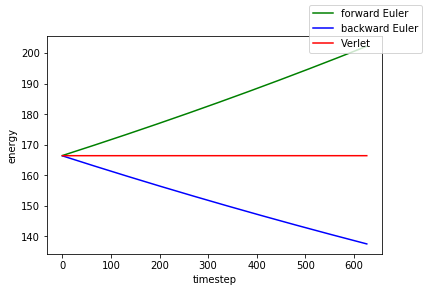

In [5]:
fig, ax = plt.subplots()
ax.plot(energy_feuler, 'g', label='forward Euler')
ax.plot(energy_beuler, 'b', label='backward Euler')
ax.plot(energy_verlet, 'r', label='Verlet')
fig.legend()
ax.set_xlabel('timestep')
ax.set_ylabel('energy')
plt.show(fig)

The energy increases and decreases with the forward and backward Euler methods, respectively.
As we take smaller timesteps, this error decreases for a given model time, but the long-time behavior of the discrete system is always wrong in one way or the other.

By contrast, the energy is approximately conserved when using the Verlet method, even for arbitrarily long integration times.

In [6]:
print((np.max(energy_verlet) - np.min(energy_verlet)) / np.mean(energy_verlet))

7.411986412040284e-05
